In [ ]:
# https://mmcv.readthedocs.io/en/latest/get_started/installation.html
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [1]:
# 런타임 다시 실행
from mmdet.apis import init_detector, inference_detector
import mmcv

## Oxford Pet Dataset 다운로드

In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2021-11-26 05:36:56--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  20.2MB/s    in 37s     

2021-11-26 05:37:34 (20.2 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2021-11-26 05:37:34--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  9.68MB/s    in 1.9s    

2021-11-26 05:37:37 (9.68 M

In [ ]:
# /content/data 디렉토리를 만들고 해당 디렉토리에 다운로드 받은 압축 파일 풀기.
!mkdir /content/data
!tar -xvf images.tar.gz -C /content/data
!tar -xvf annotations.tar.gz -C /content/data

## Annotation 파일

In [5]:
# annotation 파일
!cat ./data/annotations/xmls/Abyssinian_1.xml

<annotation><folder>OXIIIT</folder><filename>Abyssinian_1.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>600</width><height>400</height><depth>3</depth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>333</xmin><ymin>72</ymin><xmax>425</xmax><ymax>158</ymax></bndbox><difficult>0</difficult></object></annotation>


![image](https://user-images.githubusercontent.com/44194558/143534977-f10c390a-2e65-4ffa-9bf9-f5e304a0e9cf.png)

In [8]:
import glob
import xml.etree.ElementTree as ET

# annotation의 xml파일을 parsing해서 bbox 정보를 추출
def get_bboxes_from_xml_test(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bbox_names = []
    bboxes = []
    
    # xml 파일내의 모든 object 객체에 대해
    for obj in root.findall('object'):
        bbox_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        x1 = int(xmlbox.find('xmin').text)
        y1 = int(xmlbox.find('ymin').text)
        x2 = int(xmlbox.find('xmax').text)
        y2 = int(xmlbox.find('ymax').text)

        bbox_names.append(bbox_name)
        bboxes.append([x1, y1, x2, y2])

    return bbox_names, bboxes

In [9]:
get_bboxes_from_xml_test('./data/annotations/xmls/Abyssinian_1.xml')

(['cat'], [[333, 72, 425, 158]])

## train, val image/annotation 메타 파일

train/val로 나뉠 image, annotation의 파일명을 가지는 메타 파일

train/val용 메타 파일을 별도로 생성

In [10]:
import pandas as pd

pet_df = pd.read_csv('./data/annotations/trainval.txt', sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])
pet_df.head()

img_name  class_id  etc1  etc2
0  Abyssinian_100         1     1     1
1  Abyssinian_101         1     1     1
2  Abyssinian_102         1     1     1
3  Abyssinian_103         1     1     1
4  Abyssinian_104         1     1     1

In [11]:
pet_df['class_name'] = pet_df['img_name'].apply(lambda x : x[:x.rfind('_')])
pet_df.head()

img_name  class_id  etc1  etc2  class_name
0  Abyssinian_100         1     1     1  Abyssinian
1  Abyssinian_101         1     1     1  Abyssinian
2  Abyssinian_102         1     1     1  Abyssinian
3  Abyssinian_103         1     1     1  Abyssinian
4  Abyssinian_104         1     1     1  Abyssinian

In [12]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(pet_df, test_size=0.1, stratify=pet_df['class_id'], random_state=2021)

In [13]:
train_df = train_df.sort_values(by='img_name')
val_df = val_df.sort_values(by='img_name')

In [15]:
# data에 있는 images, annotations를 train/val용으로 분류할 수 있도록 함
train_df['img_name'].to_csv('./data/train.txt', sep=' ', header=False, index=False)
val_df['img_name'].to_csv('./data/val.txt', sep=' ', header=False, index=False)

In [17]:
train_df.head()

img_name  class_id  etc1  etc2  class_name
1895    Abyssinian_1         1     1     1  Abyssinian
10     Abyssinian_10         1     1     1  Abyssinian
1     Abyssinian_101         1     1     1  Abyssinian
2     Abyssinian_102         1     1     1  Abyssinian
3     Abyssinian_103         1     1     1  Abyssinian

In [18]:
val_df.head()

img_name  class_id  etc1  etc2  class_name
0   Abyssinian_100         1     1     1  Abyssinian
21   Abyssinian_11         1     1     1  Abyssinian
24  Abyssinian_122         1     1     1  Abyssinian
29  Abyssinian_127         1     1     1  Abyssinian
44  Abyssinian_140         1     1     1  Abyssinian

In [16]:
pet_classes_list = pet_df['class_name'].unique().tolist()
print(pet_classes_list)

['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


## MM detection의 middle format으로 변환

ann_file로 입력되는 메타 파일을 읽어서 개별 image에 대한 정보와 annotation 정보를 dict로 생성하여 data_infos_list에 입력

![image](https://user-images.githubusercontent.com/44194558/143533862-0c9537a6-b826-4ced-b899-d5947a8a1c31.png)

In [19]:
import xml.etree.ElementTree as ET

def get_bboxes_from_xml(anno_dir, xml_file):
    anno_xml_file = osp.join(anno_dir, xml_file)
    tree = ET.parse(anno_xml_file)
    root = tree.getroot()
    bbox_names = []
    bboxes = []

    for obj in root.findall('object'):
        # xml 파일명에서 class명 추출
        bbox_name = xml_file[:xml_file.rfind('_')]

        xmlbox = obj.find('bndbox')
        x1 = int(xmlbox.find('xmin').text)
        y1 = int(xmlbox.find('ymin').text)
        x2 = int(xmlbox.find('xmax').text)
        y2 = int(xmlbox.find('ymax').text)

        bboxes.append([x1, y1, x2, y2])
        bbox_names.append(bbox_name)

    return bbox_names, bboxes

In [20]:
import copy
import os.path as osp

import mmcv
import numpy as np
import cv2

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

import xml.etree.ElementTree as ET

PET_CLASSES = pet_df['class_name'].unique().tolist()

@DATASETS.register_module(force=True)
class PetDataset(CustomDataset):
    CLASSES = PET_CLASSES
    
    # 모든 annotation 파일명을 저장한 텍스트 파일(train.txt, val.txt)을 입력으로 받음
    # self.ann_file이 load_annotations()의 인자로 입력됨
    def load_annotations(self, ann_file):
        cat2label = {k:i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)  # train/val.txt에 있는 모든 객체들의 리스트  ex) Abyssinian_1, Abyssinian_10, ...
        data_infos = []  # middle format 데이터를 저장

        for image_id in image_list:
            # data/images에 있는 개별 image 파일들을 하나씩 읽음  ex) data/images/Abyssinian_1.jpg
            filename = '{0:}/{1:}.jpg'.format(self.img_prefix, image_id)  
            image = cv2.imread(filename)
            height, width = image.shape[:2]

            data_info = {'filename': str(image_id) + '.jpg',
                         'width': width, 'height': height}

            # data/images -> data/annotations
            label_prefix = self.img_prefix.replace('images', 'annotations')
            # data/annotations/xmls의 개별 xml 파일들을 하나씩 읽음
            anno_xml_file = osp.join(label_prefix, 'xmls/'+str(image_id)+'.xml')

            if not osp.exists(anno_xml_file):
                continue

            # 개별 XML 파일에 있는, 이미지에 대한 모든 bbox 정보를 list 객체로 생성.
            anno_dir = osp.join(label_prefix, 'xmls')
            bbox_names, bboxes = get_bboxes_from_xml(anno_dir, str(image_id)+'.xml')

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
            
            # bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_bboxes.append(bbox)
                    gt_labels.append(cat2label[bbox_name])

                else:
                    gt_bboxes_ignore.append(bbox)
                    gt_labels_ignore.append(-1)

            data_anno = {
              'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
              'labels': np.array(gt_labels, dtype=np.long),
              'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
              'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
            }
            
            # 'ann' key값으로 data_anno 정보를 value로 저장
            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [27]:
import os.path as osp

PET_CLASSES = pet_df['class_name'].unique().tolist()

# 디버깅 용도로 CustomDataset을 흉내낸 클래스 생성. 
class PetDataset_imsi():
    CLASSES = PET_CLASSES

    def __init__(self, data_root, ann_file, img_prefix):
        self.data_root = data_root
        self.ann_file = osp.join(data_root, ann_file)
        self.img_prefix = osp.join(data_root, img_prefix)

        self.data_infos = self.load_annotations(self.ann_file)

    def load_annotations(self, ann_file):
        cat2label = {k:i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
        data_infos = []

        for image_id in image_list:
            filename = '{0:}/{1:}.jpg'.format(self.img_prefix, image_id)
            image = cv2.imread(filename)
            height, width = image.shape[:2]

            data_info = {'filename': str(image_id) + '.jpg', 
                         'width': width, 'height': height}

            label_prefix = self.img_prefix.replace('images', 'annotations')
            anno_xml_file = osp.join(label_prefix, 'xmls/'+str(image_id)+'.xml')

            if not osp.exists(anno_xml_file):
                continue

            anno_dir = osp.join(label_prefix, 'xmls')
            bbox_names, bboxes = get_bboxes_from_xml(anno_dir, str(image_id)+'.xml')

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []

            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_bboxes.append(bbox)
                    gt_labels.append(cat2label[bbox_name])
            else:
                gt_bboxes_ignore.append(bbox)
                gt_labels_ignore.append(-1)

            data_anno = {
              'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
              'labels': np.array(gt_labels, dtype=np.long),
              'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
              'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
              }

            data_info.update(ann=data_anno)
            data_infos.append(data_info)
      
        return data_infos

In [28]:
train_ds = PetDataset_imsi(data_root='/content/data', ann_file='train.txt', img_prefix='images')
print(train_ds.data_infos[:10])

[{'filename': 'Abyssinian_1.jpg', 'width': 600, 'height': 400, 'ann': {'bboxes': array([[333.,  72., 425., 158.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([[333.,  72., 425., 158.]], dtype=float32), 'labels_ignore': array([-1])}}, {'filename': 'Abyssinian_10.jpg', 'width': 375, 'height': 500, 'ann': {'bboxes': array([[ 72., 105., 288., 291.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([[ 72., 105., 288., 291.]], dtype=float32), 'labels_ignore': array([-1])}}, {'filename': 'Abyssinian_101.jpg', 'width': 450, 'height': 313, 'ann': {'bboxes': array([[ 54.,  36., 319., 235.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([[ 54.,  36., 319., 235.]], dtype=float32), 'labels_ignore': array([-1])}}, {'filename': 'Abyssinian_102.jpg', 'width': 500, 'height': 465, 'ann': {'bboxes': array([[ 23.,  27., 325., 320.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([[ 23.,  27., 325., 320.]], dtype=float32), 'labels_ignore': array

## Config 설정 & Pretrained 모델 다운로드

In [29]:
config_file = './mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = './mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [30]:
!cd mmdetection; mkdir checkpoints
!wget -O ./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2021-11-26 06:48:57--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.59
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

./mmdetection/check 100%[===================>] 159.54M  10.6MB/s    in 15s     

2021-11-26 06:49:12 (10.7 MB/s) - ‘./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [31]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [32]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [33]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

 base_model_with_crf_val		   monologg
 bq-results-20191224-175502-9t7tewhib882   ner_dataset.csv
 bq-results-20191224-175502-boyp8ke46rov   news_articles_ner.csv
 camera					   practice_DCGAN
 cats_and_dogs_small			   ratings_test.txt
 cats_and_dogs_small_2.h5		   ratings_train.txt
 cGAN					   scratches
 Classroom				   StarGAN
'Colab Notebooks'			   train.txt
 cycleGAN				   Untitled0.ipynb
 DCGAN_PRACTICE				   Untitled1.ipynb
 glove.6B.100d.txt			   vocab.txt
 LSGAN					   wgan
 models					   wgan_gp


In [34]:
!mkdir "/mydrive/pet_work_dir"

In [35]:
!nvidia-smi

Fri Nov 26 06:50:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Config 설정 변경

In [36]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'PetDataset'
cfg.data_root = '/content/data/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'PetDataset'
cfg.data.train.data_root = '/content/data/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'PetDataset'
cfg.data.val.data_root = '/content/data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'images'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 37
# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리로 구글 Drive 설정. 
cfg.work_dir = '/mydrive/pet_work_dir'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 5

cfg.runner.max_epochs = 5

# 평가 metric 설정. 
cfg.evaluation.metric = 'mAP'
# 평가 metric 수행할 epoch interval 설정. 
cfg.evaluation.interval = 5
# 학습 iteration시마다 모델을 저장할 epoch interval 설정. 
cfg.checkpoint_config.interval = 5

# 학습 시 Batch size 설정(단일 GPU 별 Batch size로 설정됨)
cfg.data.samples_per_gpu = 4

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'

In [37]:
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

## Train

In [38]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]

/usr/local/lib/python3.7/dist-packages/mmdet-2.18.1-py3.7.egg/mmdet/datasets/custom.py:157: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


In [39]:
datasets

[
 PetDataset Train dataset with number of images 3304, and instance counts: 
 +-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
 | category              | count | category                | count | category                      | count | category            | count | category                        | count |
 +-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
 | 0 [Abyssinian]        | 89    | 1 [american_bulldog]    | 90    | 2 [american_pit_bull_terrier] | 90    | 3 [basset_hound]    | 90    | 4 [beagle]                      | 90    |
 | 5 [Bengal]            | 89    | 6 [Birman]              | 90    | 7 [Bombay]                    | 86    | 8 [boxer]           | 90    | 9 [British_Shorthair]           | 90    |
 | 10 [chihuahua]

In [40]:
%cd mmdetection

model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection


2021-11-26 07:06:42,835 - mmdet - INFO - load checkpoint from local path: checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2021-11-26 07:06:42,965 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([38, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([38]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([148, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([148]).
2021-11-26 07:06:42,972 - mmdet - INFO - Start running, host: root@2539eee0718d, work_dir: /mydriv

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 367/367, 12.4 task/s, elapsed: 30s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-11-26 07:52:37,160 - mmdet - INFO - 
+----------------------------+-----+------+--------+-------+
| class                      | gts | dets | recall | ap    |
+----------------------------+-----+------+--------+-------+
| Abyssinian                 | 10  | 62   | 0.800  | 0.326 |
| american_bulldog           | 10  | 72   | 1.000  | 0.704 |
| american_pit_bull_terrier  | 10  | 74   | 1.000  | 0.696 |
| basset_hound               | 10  | 50   | 0.900  | 0.818 |
| beagle                     | 10  | 76   | 0.900  | 0.591 |
| Bengal                     | 10  | 106  | 1.000  | 0.433 |
| Birman                     | 10  | 68   | 1.000  | 0.581 |
| Bombay                     | 10  | 91   | 0.900  | 0.721 |
| boxer                      | 10  | 107  | 1.000  | 0.481 |
| British_Shorthair          | 10  | 54   | 1.000  | 0.712 |
| chihuahua                  | 10  | 50   | 0.600  | 0.550 |
| Egyptian_Mau               | 9   | 48   | 0.889  | 0.489 |
| english_cocker_spaniel     | 10  | 46   |

## Inference

/usr/local/lib/python3.7/dist-packages/mmdet-2.18.1-py3.7.egg/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


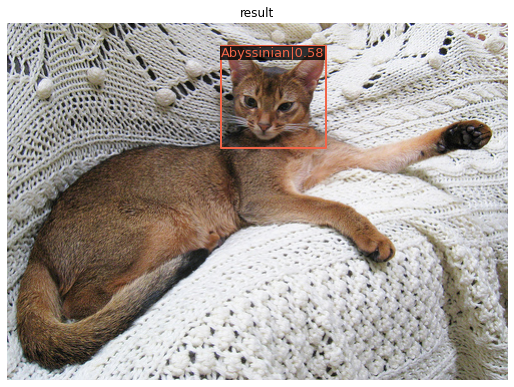

In [41]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/data/images/Abyssinian_88.jpg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

In [42]:
result

[array([[213.56349  ,  23.393707 , 318.71954  , 125.01079  ,   0.5835209]],
       dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.14623535e+02, 1.86498928e+01, 3.25177338e+02, 1.18434235e+02,
         2.24426985e-01]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.2123997e+02, 1.9716713e+01, 3.1397617e+02, 1.2139336e+02,
         2.1959019e-01]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(

load checkpoint from local path: /mydrive/pet_work_dir/epoch_5.pth


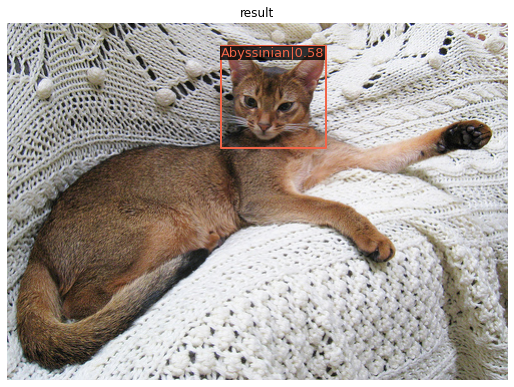

In [43]:
from mmdet.apis import show_result_pyplot

# checkpoint에 저장된 모델 파일을 로딩하여 inference 수행
checkpoint_file = '/mydrive/pet_work_dir/epoch_5.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')
# BGR Image 사용 
img = cv2.imread('/content/data/images/Abyssinian_88.jpg')
#model_ckpt.cfg = cfg

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.3)

## 다수의 이미지에 대한 inference

inference_detector(model, imgs)에서 인자 imgs는 단일 이미지인 경우 string/array, 다수의 이미지의 경우 list(string/arrary) 입력

In [44]:
val_df['img_path'] = '/content/data/images/' + val_df['img_name'] + '.jpg'
val_df.head()

img_name  ...                                 img_path
0   Abyssinian_100  ...  /content/data/images/Abyssinian_100.jpg
21   Abyssinian_11  ...   /content/data/images/Abyssinian_11.jpg
24  Abyssinian_122  ...  /content/data/images/Abyssinian_122.jpg
29  Abyssinian_127  ...  /content/data/images/Abyssinian_127.jpg
44  Abyssinian_140  ...  /content/data/images/Abyssinian_140.jpg

[5 rows x 6 columns]

In [45]:
val_df[val_df['img_path'].str.contains('Abyssinian')]['img_path'].values

array(['/content/data/images/Abyssinian_100.jpg',
       '/content/data/images/Abyssinian_11.jpg',
       '/content/data/images/Abyssinian_122.jpg',
       '/content/data/images/Abyssinian_127.jpg',
       '/content/data/images/Abyssinian_140.jpg',
       '/content/data/images/Abyssinian_153.jpg',
       '/content/data/images/Abyssinian_158.jpg',
       '/content/data/images/Abyssinian_182.jpg',
       '/content/data/images/Abyssinian_190.jpg',
       '/content/data/images/Abyssinian_193.jpg'], dtype=object)

In [46]:
val_paths = val_df[val_df['img_path'].str.contains('Abyssinian')]['img_path'].values
val_imgs = [cv2.imread(x) for x in val_paths]

In [61]:
type(val_imgs), len(val_imgs), val_imgs[0].shape, val_imgs[1].shape

(list, 10, (500, 376, 3), (456, 500, 3))

In [62]:
results = inference_detector(model_ckpt, val_imgs)

In [63]:
len(results), len(results[0])

(10, 37)

In [64]:
results[0]

[array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[1.0389542e+01, 2.8841463e+01, 2.9334079e+02, 3.4594159e+02,
         1.2754075e-01]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[6.2594566e+00, 0.0000000e+00, 2.9483154e+02, 3.3836084e+02,
         6.1505534e-02]], dtype=float32),

In [67]:
PET_CLASSES = pet_df['class_name'].unique().tolist()
labels_to_names_seq = {i:k for i, k in enumerate(PET_CLASSES)}

def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
 
    draw_img = img_array.copy()
    bbox_color=(0, 255, 0)
    text_color=(0, 0, 255)

    results = inference_detector(model, img_array)

    for result_ind, result in enumerate(results):
        if len(result) == 0:
            continue

        result_filtered = result[np.where(result[:, 4] > score_threshold)]
    
        for i in range(len(result_filtered)):
            left = int(result_filtered[i, 0])
            top = int(result_filtered[i, 1])
            right = int(result_filtered[i, 2])
            bottom = int(result_filtered[i, 3])
      
            caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
            cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 1)
            if is_print:
                print(caption)

    return draw_img

Abyssinian: 0.5835


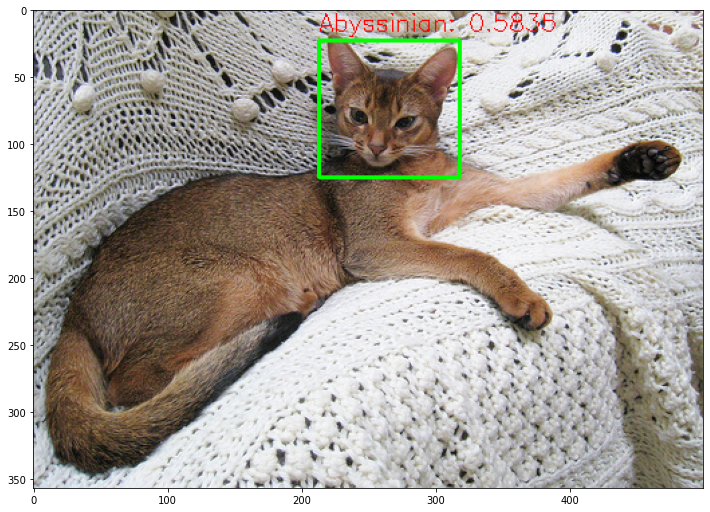

In [68]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/content/data/images/Abyssinian_88.jpg')
detected_img = get_detected_img(model, img_arr,  score_threshold=0.3, is_print=True)
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(detected_img)

Persian: 0.5878
Persian: 0.9194
Persian: 0.8616
Persian: 0.6827
Persian: 0.6526
Persian: 0.5723
Persian: 0.6445
Ragdoll: 0.5973
Persian: 0.9055


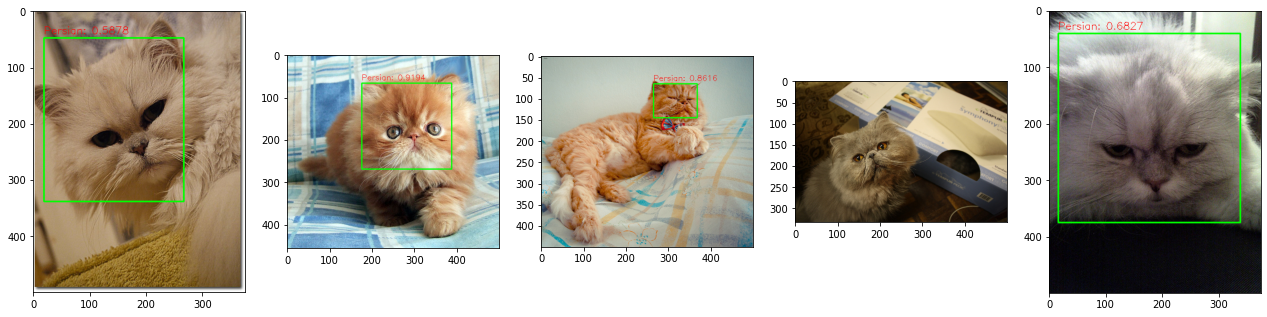

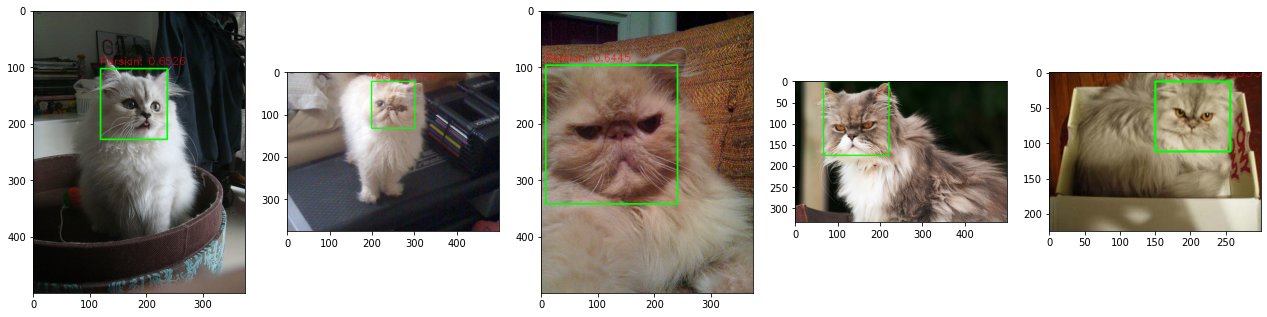

In [69]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline 

def show_detected_images(model, img_arrays, ncols=5):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
      detected_img = get_detected_img(model, img_arrays[i],  score_threshold=0.5, is_print=True)
      detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
      #detected_img = cv2.resize(detected_img, (328, 328))
      axs[i].imshow(detected_img)

        
show_detected_images(model_ckpt, val_imgs[:5], ncols=5)
show_detected_images(model_ckpt, val_imgs[5:10], ncols=5)

Persian: 0.5878
Persian: 0.9194
Persian: 0.8616
Persian: 0.6827
Persian: 0.6526
Persian: 0.5723
Persian: 0.6445
Ragdoll: 0.5973
Persian: 0.9055


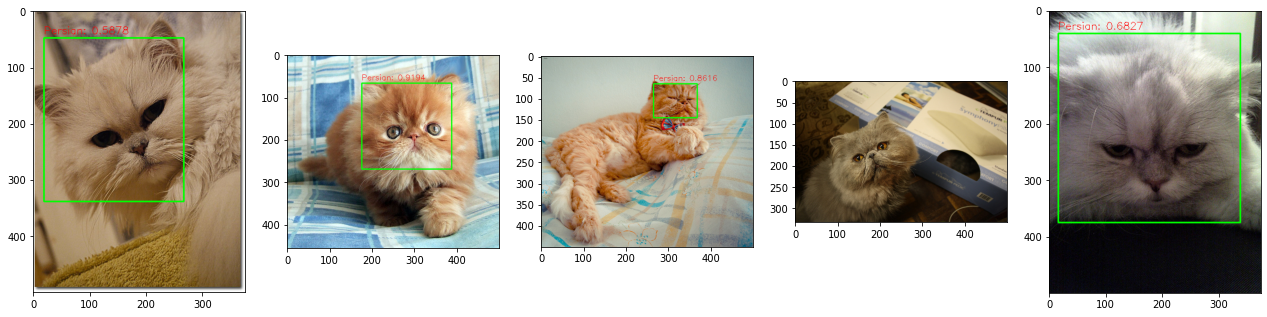

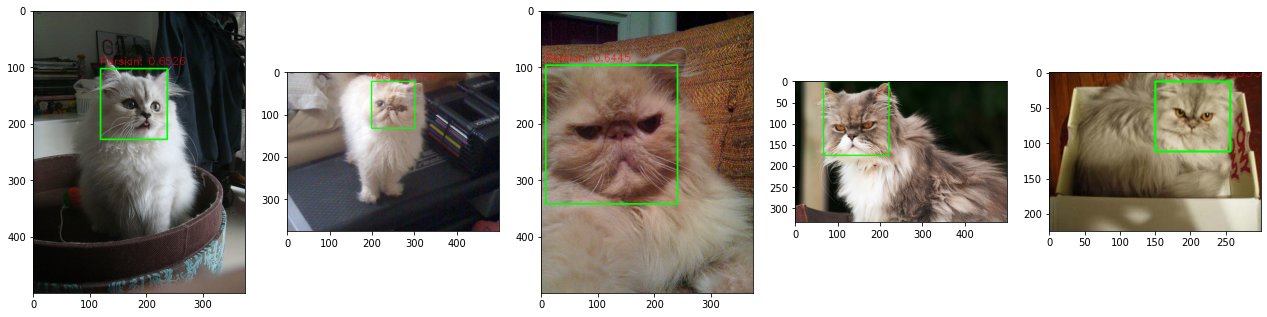

In [72]:
val_paths = val_df[val_df['img_path'].str.contains('Persian')]['img_path'].values
val_imgs = [cv2.imread(x) for x in val_paths]

show_detected_images(model_ckpt, val_imgs[:5], ncols=5)
show_detected_images(model_ckpt, val_imgs[5:10], ncols=5)